# Bayesian Ridge model on the cattle dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns

from sklearn.linear_model import BayesianRidge
from scipy.stats import f_oneway
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


## Load the data and preprocess

In [2]:
#Load in the dataset
df = pd.read_excel("C:/Users/daanm/Documents/Universiteit Utrecht/Scriptie/cattle_df.xlsx")
df = df.drop(['Unnamed: 0','advise_vip','purchase_bin','cs_cs_ratio_post_cattle','buy_nr_cattle','buy_cattle', 'ratio_insured_cattle', 'n_previd_cattle','wave', 'id'], axis=1)
df.head()

,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_cattle,number_minors,...,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip
0,No,25,Yes,No,Never attended,No,0,1,-188.170624,2,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes
1,Yes,27,Yes,No,Adult Education,No,0,0,-850.367249,2,...,Not working,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
2,Yes,29,No,No,Elementary,No,1,0,-5219.686523,2,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Professional and Organizational Sources,Christian,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
3,No,35,Yes,No,Never attended,No,0,0,-157.544266,3,...,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes
4,No,60,Yes,No,Never attended,No,0,0,-158.881271,1,...,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes


In [1]:
#Tranform the outcome varialbe to improve the distribution
df['cs_diff_log'] = np.log(np.abs(df['cs_cs_diff_post_cattle']) + 1)
df[['cs_cs_diff_post_cattle', 'cs_diff_log']].head()

NameError: name 'np' is not defined

In [4]:
y = df['cs_diff_log']
X = df.drop(columns=['cs_diff_log', 'cs_cs_diff_post_cattle'])

In [5]:
categorical = X.select_dtypes(include=['object','category']).columns.tolist()
numerical = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [6]:
X_encoded = X.copy()

# Encode categorical variables
label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

# Scale the numerical variables
scaler = StandardScaler()
X_encoded[numerical] = scaler.fit_transform(X_encoded[numerical])


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

## Deploy the model

In [7]:
bayes_model = BayesianRidge()
bayes_model.fit(X_train, y_train)

BayesianRidge()

In [8]:
y_pred = bayes_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²-score: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

R²-score: -0.009
MAE: 1.204
RMSE: 1.656


## Gridsearch with Cross Validation

To find the best model, we will be applying grid search to this method

In [9]:
#Define the grid for the parameters
param_grid = {
    "alpha_1": [1e-2, 1e-3, 1e-4, 1e-5, 1e-1, 1],
    "alpha_2": [1e-2, 1e-3, 1e-4, 1e-5, 1e-1, 1],
    "lambda_1": [1e-2, 1e-3, 1e-4, 1e-5, 1e-1, 1],
    "lambda_2": [1e-2, 1e-3, 1e-4, 1e-5, 1e-1, 1]
}

bayesian_grid = BayesianRidge()

grid_search = GridSearchCV(bayesian_grid, param_grid, cv=5, scoring="r2", n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=BayesianRidge(), n_jobs=-1,
             param_grid={'alpha_1': [0.01, 0.001, 0.0001, 1e-05, 0.1, 1],
                         'alpha_2': [0.01, 0.001, 0.0001, 1e-05, 0.1, 1],
                         'lambda_1': [0.01, 0.001, 0.0001, 1e-05, 0.1, 1],
                         'lambda_2': [0.01, 0.001, 0.0001, 1e-05, 0.1, 1]},
             return_train_score=True, scoring='r2')

In [10]:
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

results_summary = []

#Rerun the gridsearchCV and store all the values of the performance metrics

for i, row in results_df.iterrows():
    params = row['params']
    
    model = BayesianRidge(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results_summary.append({
        'Parameters': params,
        'R²': round(r2, 3),
        'MAE': round(mae, 3),
        'RMSE': round(rmse, 3)
    })


summary_df = pd.DataFrame(results_summary)

summary_df = summary_df.sort_values(by='R²', ascending=False).reset_index(drop=True)
styled_df = summary_df.style.background_gradient(subset=['R²'], cmap='Greens')

styled_df

,Parameters,R²,MAE,RMSE
0,"{'alpha_1': 0.01, 'alpha_2': 1, 'lambda_1': 1, 'lambda_2': 0.0001}",-0.007000,1.203000,1.655000
1,"{'alpha_1': 1e-05, 'alpha_2': 1, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000
2,"{'alpha_1': 0.01, 'alpha_2': 0.001, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000
3,"{'alpha_1': 0.01, 'alpha_2': 1e-05, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000
4,"{'alpha_1': 1e-05, 'alpha_2': 1e-05, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000
5,"{'alpha_1': 0.0001, 'alpha_2': 0.0001, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000
6,"{'alpha_1': 0.0001, 'alpha_2': 1e-05, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000
7,"{'alpha_1': 0.001, 'alpha_2': 0.001, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000
8,"{'alpha_1': 0.01, 'alpha_2': 0.0001, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000
9,"{'alpha_1': 0.01, 'alpha_2': 0.01, 'lambda_1': 1, 'lambda_2': 1e-05}",-0.007000,1.203000,1.655000


C:\Users\daanm\AppData\Local\Temp\ipykernel_14760\135842769.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Absolute Coefficient", y="Feature", data=top_features_df, palette="mako")


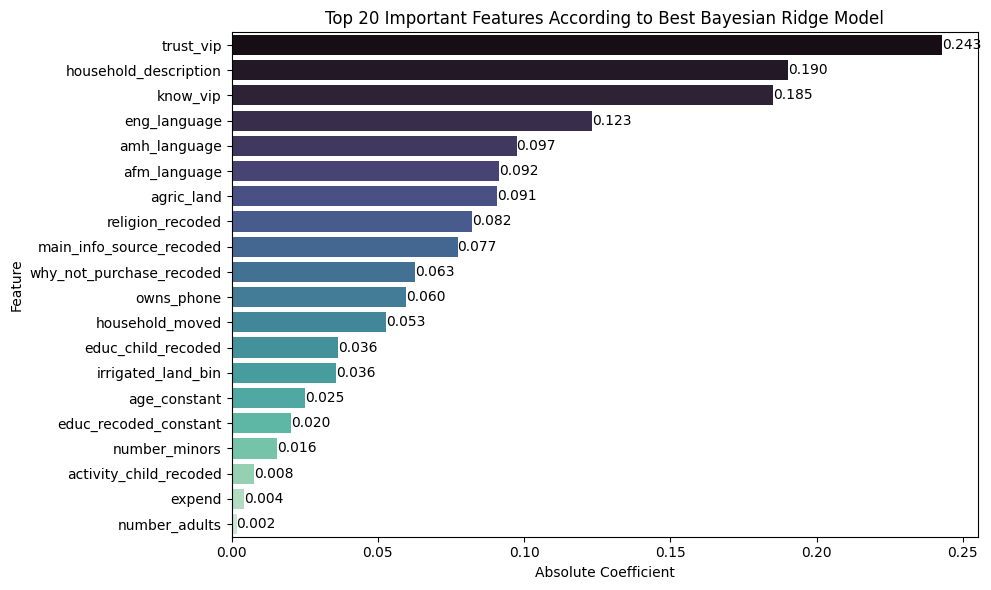

In [11]:
# Get coefficients from best performing Bayesian model
coefficients = grid_search.best_estimator_.coef_

feature_names = X_train.columns

# Make the coefficients dataframe
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Absolute Coefficient": np.abs(coefficients)
})

# Filter alleen niet-nul waarden
coef_df = coef_df[coef_df["Coefficient"] != 0]
top_features_df = coef_df.sort_values(by="Absolute Coefficient", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Absolute Coefficient", y="Feature", data=top_features_df, palette="mako")
plt.title("Top 20 Important Features According to Best Bayesian Ridge Model")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")

for i, value in enumerate(top_features_df["Absolute Coefficient"]):
    ax.text(value, i, f'{value:.3f}', color='black', va='center')

plt.tight_layout()
plt.savefig("top_features_bayesianridge_cattle_v2.png", dpi=300)
plt.show()
